# Named Entity Recognition (NER)

Named-entity recognition (NER) (also known as entity identification, entity chunking and entity extraction) is a subtask of information extraction that seeks to locate and classify named entities mentioned in unstructured text into pre-defined categories such as person names, organizations, locations, medical codes, time expressions, quantities, monetary values, percentages, etc.

In [ ]:
import os 
import numpy as np
import pandas as pd
import random as rnd

In [ ]:
# display original kaggle data
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Datasets/ner_dataset.csv", encoding = "ISO-8859-1") 
train_sents = open('/content/drive/MyDrive/Colab Notebooks/Datasets/sentences.txt', 'r').readline()
train_labels = open('/content/drive/MyDrive/Colab Notebooks/Datasets/labels.txt', 'r').readline()
print('SENTENCE:', train_sents)
print('SENTENCE LABEL:', train_labels)
print('ORIGINAL DATA:\n', data.head(5))

SENTENCE: Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .

SENTENCE LABEL: O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O

ORIGINAL DATA:
     Sentence #           Word  POS Tag
0  Sentence: 1      Thousands  NNS   O
1          NaN             of   IN   O
2          NaN  demonstrators  NNS   O
3          NaN           have  VBP   O
4          NaN        marched  VBN   O


## Extract mappings required for the neural network

1. To train a neural network, we will use two mappings as given below.
{token} to {token id}: address the row in embeddings matrix for the current token.

2. {tag} to {tag id}: one-hot ground truth probability distribution vectors for computing the loss at the network’s output.

This step is desired in any machine learning model, including the neural-network, which requires integers as input.

In [ ]:
from itertools import chain

In [ ]:
def get_dict_map(data,tag_or_token):
  tok2idx = {}
  idx2tok = {}

  if tag_or_token == 'token':
    vocab = list(set(data['Word'].to_list()))

  else:
    vocab = list(set(data['Tag'].to_list()))

  tok2idx = {tok:idx for idx,tok in enumerate(vocab)}
  idx2tok = {idx:tok for idx,tok in enumerate(vocab)}

  return tok2idx, idx2tok

In [ ]:
token_to_idx, idx_to_token = get_dict_map(data,'token')

In [ ]:
tag_to_idx, idx_to_tag = get_dict_map(data,'tag')

In [ ]:
data['Word_to_idx'] = data['Word'].map(token_to_idx)

data['Tag_to_idx'] = data['Tag'].map(tag_to_idx)

data.head()

,Sentence #,Word,POS,Tag,Word_to_idx,Tag_to_idx
0,Sentence: 1,Thousands,NNS,O,3963,13
1,NaN,of,IN,O,27645,13
2,NaN,demonstrators,NNS,O,24394,13
3,NaN,have,VBP,O,8012,13
4,NaN,marched,VBN,O,7655,13


In [ ]:
token_to_idx['Thousands']

3963

We can see that the function has added two new index columns for our X (Word_to_idx) and y (Tag_to_idx) variables. Next, let us collect tokens into arrays in the respective sequence to make the recurrent neural network’s best use.

# Transform columns to extract sequential data

To transform columns into sequential arrays, we will


1. Fill NaN in the ‘sentence #’ column using method ffill in fillna.
2. After that, run groupby on the sentence column to get a list of tokens and tags.

In [ ]:
data_fill_NA = data.fillna(method ='ffill', axis = 0)

group_by_data = data_fill_NA.groupby(['Sentence #'], as_index = False)

In [ ]:
group_by_data = group_by_data['Word','POS','Tag','Word_to_idx','Tag_to_idx'].agg(lambda x: list(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [ ]:
group_by_data.head()

,Sentence #,Word,POS,Tag,Word_to_idx,Tag_to_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[3963, 27645, 24394, 8012, 7655, 7716, 15591, ...","[13, 13, 13, 13, 13, 13, 3, 13, 13, 13, 13, 13..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[26223, 24420, 32324, 1978, 13469, 14954, 2834...","[15, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[11149, 25484, 9547, 8433, 4685, 7409, 30994, ...","[13, 13, 4, 13, 13, 13, 13, 13, 3, 13, 13, 13,..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[1701, 30439, 26074, 34336, 11783, 34819, 6462...","[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[27019, 3600, 27484, 26195, 7786, 23434, 8713,...","[3, 13, 13, 7, 10, 13, 4, 13, 3, 13, 15, 13, 1..."


# Split the dataset into train, test after padding

##Padding:  
The LSTM layers accept sequences of the same length only. Therefore, every sentence represented as integers (‘Word_idx’) must be padded to have the same length. We will work with the max length of the longest sequence and pad the shorter sequences to achieve this.
Please note we can use shorter padding lengths as well. In that case, you will be padding the shorter sequences and truncating the longer sequences.
We will also be converting the y variable as one-hot encoded vector using the to_categorical function in Keras. Let us import the required packages.

In [ ]:
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [ ]:
def get_pad_sequence(data_group,data):

  #get max token and tag length

  n_tokens = len(list(set(data['Word'].to_list())))
  n_tag = len(list(set(data['Tag'].to_list())))

  #Pad Tokens
  tokens = data_group['Word_to_idx'].to_list()
  maxlen = max([len(t) for t in tokens])
  pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype= 'int32',padding='post', value= n_tokens-1)

  #Pad Tags and convert into one hot encoding
  tags = data_group['Tag_to_idx'].to_list()
  pad_tags = pad_sequences(tags, maxlen=maxlen,dtype='int32', padding='post',value=tag_to_idx['O'])
  n_tags = len(tag_to_idx)
  pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]

  #Split train, test and validation set
  tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, 
                                                            test_size=0.1, train_size=0.9,random_state=2020)
  train_tokens,val_tokens,train_tags,val_tags = train_test_split(tokens_, tags_, test_size=0.25, 
                                                                 train_size=0.75,random_state=2020)
  
  print('train_tokens length:', len(train_tokens),
        '\ntrain_tokens length:', len(train_tags),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags)
        )
  
  return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

In [ ]:
train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_sequence(group_by_data, data)

train_tokens length: 32372 
train_tokens length: 32372 
test_tokens length: 4796 
test_tags: 4796 
val_tokens: 10791 
val_tags: 10791


In [ ]:
for token, tag in zip(train_tokens[0], train_tags[0]):
    print('%s\t%s' % (token, tag))

32152	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
25848	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
31313	[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
12831	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
10262	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
30370	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
12981	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
7195	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
10164	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
21937	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
34336	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
27111	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
5471	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
14954	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
10974	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
12981	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
13811	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

# Build the model architecture

Neural network models work with graphical structure. Therefore we will first need to design the architecture and set input and out dimensions for every layer. RNNs are capable of handling different input and output combinations. We will use many to many architectures for this task.

In [ ]:
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

In [ ]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In this architecture, we are primarily working with three layers (embedding, bi-lstm, lstm layers) and the 4th layer, which is TimeDistributed Dense layer, to output the result.

#### Layer 1 — Embedding layer: 
We will specify the maximum length (104) of the padded sequences. After the network is trained, the embedding layer will transform each token into a vector of n dimensions. We have chosen the n dimensions to be (32).
The dimensions (?, 104, 32) that we see in the given neural network plot’s embedding layer comes from these specifications. Please note the 1st dimension shows ‘?’ or None in the plots. They represent the batch sizes. If it is not provided, they show ‘?’ or None, which means the model can take any batch size.

#### Layer 2 — Bidirectional LSTM: 
Bidirectional lstm takes a recurrent layer (e.g. the first LSTM layer) as an argument. This layer takes the output from the previous embedding layer (104, 32).
Since this is bidirectional lstm, we will have forward and backward outputs. Combine these outputs before passing this to the next layer by summing or taking average or concatenating or multiplying. Find these functions in the merge mode argument in bi-lstm layer. The outputs are concatenated in the default mode, which in turn doubles the number of outputs to the next layer. In our case, it becomes 64(32 * 2).

#### Layer 3 — LSTM Layer: 
An LSTMnetwork is a recurrent neural network that has LSTM cell blocks in place of our standard neural network layers. These cells have various components called the input gate, forget gate, and output gate.
This layer takes the output dimension from the previous bidirectional lstm layer (?, 104, 128) and outputs (?, 104, 256)

#### Layer 4 — TimeDistributed Layer: 
We are dealing with Many to Many RNN Architecture, where we expect output from every input sequence. Here is an example, in the sequence (a1 →b1, a2 →b2…an →bn), a, and b are inputs and outputs of every sequence. The TimeDistributeDense layers allow Dense(fully-connected) operation across every output over every time-step. No using this layer will result in one final output.
This layer takes the output dimension of the previous lstm layer (104, 256) and outputs the max sequence length (104) and max tags (17).

In [ ]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 32
input_length = max([len(s) for s in group_by_data['Word_to_idx'].to_list()])
n_tags = len(tag_to_idx)

In [ ]:
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  35179 
output_dim:  32 
input_length:  104 
n_tags:  17


Given below is the code used to build the model architecture we discussed above. Before fitting the model, check the model graph by plotting the model using plot_model function or run model.summary() for the model summary.

In [ ]:
def get_bilstm_lstm_model():

  Model = Sequential()

  Model.add(Embedding(input_dim=input_dim, output_dim=output_dim,input_length=input_length))

  Model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2,
                               recurrent_dropout=0.2),merge_mode='concat'))
  
  Model.add(LSTM(units=output_dim,return_sequences=True, dropout=0.5,recurrent_dropout=0.5))

  Model.add(TimeDistributed(Dense(n_tags,activation='relu')))

  adam = keras.optimizers.Adam(lr=0.0005,beta_1=0.9,beta_2=0.999)

  Model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  Model.summary()
    
  return Model

In [ ]:
def train_model(X, y, model):
    loss = list()
    for i in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 32)           1125728   
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 64)           16640     
_________________________________________________________________
lstm_1 (LSTM)                (None, 104, 32)           12416     
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 17)           561       
Total params: 1,155,345
Trainable params: 1,155,345
Non-trainable params: 0
_________________________________________________________________


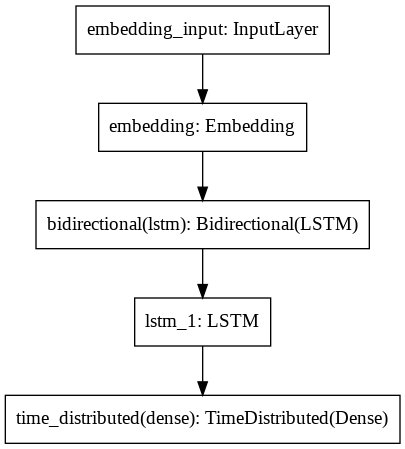

In [ ]:
results = pd.DataFrame()

model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)

In [ ]:
results['with_add_lstm'] = train_model(train_tokens,np.array(train_tags),model_bilstm_lstm)

26/26 [==============================] - 60s 2s/step - loss: 0.1173 - accuracy: 0.9682 - val_loss: 0.1277 - val_accuracy: 0.9685


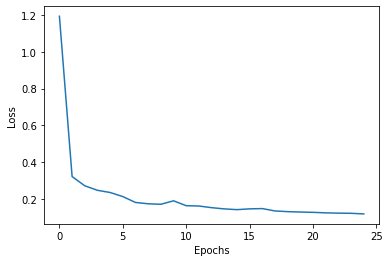

In [ ]:
import matplotlib.pyplot as plt
plt.plot(results['with_add_lstm'])
plt.xlabel('Epochs');
plt.ylabel('Loss');

In [ ]:
model_bilstm_lstm.save('my.h5')

# Spacy Entities

In [ ]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
text = nlp(
    'Jim bought 300 shares of Acme Corp. in 2006. And producing an annotated block of text that \
    highlights the names of entities: [Jim]Person bought 300 shares of \
    [Acme Corp.]Organization in [2006]Time. In this example, a person name consisting \
    of one token, a two-token company name and a temporal expression have been detected \
    and classified.State-of-the-art NER systems for English produce near-human performance. \
    For example, the best system entering MUC-7 scored 93.39% of F-measure while human \
    annotators scored 97.60% and 96.95%.[1][2]')

In [ ]:
for w in text.ents:
  print(w.text,w.label_)

Jim PERSON
300 CARDINAL
Acme Corp. ORG
2006 DATE
300 CARDINAL
Acme Corp.]Organization WORK_OF_ART
2006]Time CARDINAL
one CARDINAL
two CARDINAL
NER ORG
English LANGUAGE
MUC-7 CARDINAL
93.39% PERCENT
97.60% PERCENT


In [ ]:
spacy.explain('CARDINAL')

'Numerals that do not fall under another type'

In [ ]:
displacy.render(text, style = 'ent', jupyter=True)

In [ ]:
results

,with_add_lstm
0,1.193699
1,0.320686
2,0.270461
3,0.245851
4,0.233949
5,0.211679
6,0.179673
7,0.172501
8,0.169850
9,0.188695


In [ ]:
from keras.models import load_model

model = load_model('my.h5')

#make predictions

yhat=model.predict(val_tokens,verbose=0)

In [ ]:
yhat[0] == val_tags[0]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)